In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import csv

%matplotlib inline
pd.options.display.max_colwidth = 144

## Loading
First of all load all the data (files) we need for this project
- the enhanced twitter file provided
- the prediction file residing on the internet
- the twitter archive by means of the twitter api 


In [2]:
df_twitter = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
df_twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


In [4]:
# open the url
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r=requests.get(url)

# check if it can be retrieved if so read/write the file
if r.status_code == 200:
    if url.find('/'):
        prediction_file_name = url.rsplit('/', 1)[1]              
        open(prediction_file_name,'wb').write(r.content)
    
else:
    print('open did not succeed')

In [5]:
# reopen the file and create a dataframe for it
df_predict= pd.read_csv(prediction_file_name,sep='\t')
df_predict.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [6]:
# the twitter api is in a seperate file for ease of developing this notebook
# therefore the call to read_twitter is commented out during development (used once to create the file)

from Read_twitter import read_twitter
tweets_id=list(df_twitter.tweet_id)

#read_twitter(tweets_id)

#read the file from twitter back into the notebook
df_extra=pd.read_json('tweets_json.txt',lines=True)
df_extra.head(1)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indic...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-b...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


## Check for quality and Tidiness problems in the data

In the next text blok alle issues are summarised.
The assesment and the cleaning of the data is done below this blok, just follow the links.

For me an itterative approach in searching for quality problems and solving them directly after it is found is more natural way of working.




### Quality problems


#### In the enhanced twitter data

1. [Contains retweets](#retweets)
Enhanced twitter file contains retweets as described in the project plan. 
The retweet status is an indacation for that.

2. [Remove alle not needen columns](#Remove)

3. [Timestamp is not datetime object](#timestamp)
The Timestamp field should be a datetime field instead of a object field

4. [Source field should be catagorical](#source)
The source field contains only four different URL's. Better to transform it in a catagorical dtype. For analysis it is easier to make it a shorter value

5. [Tweetid should be string](#tweetid)
The tweetid is a Int64 but should be a string

6. [The rating should be a float](#ratings)
7. [The ratings are not correct extracted](#ratings)

8. [Dognames not correct](#dognames)
Not all the names in the column name are actual dognames. This should be cleaned.

#### In the prediction data

9. [Column names in prediction file](#predict)
The column names are not very descriptive. Should be changed in more meaningfull names.

#### In the data from twitter
The data as extracted from twitter will only be used to get the retweet count and favorites count. Details of the columns can be found in this document: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet
No further cleaning therefore conducted


### Tidiness problem enhanched twitter data
1. [doggo, floofer, pupper and puppo](#puppo)
are values should be in one column instead of four.

2. [Combine in one dataframe](#combine)
The three dataframes should be combined. They form one set of obeservations.


## Copy the dataframes

Perform the assesment on the original dataframes, perform the cleaning on the copied dataframes.

In [7]:
clean_twitter = df_twitter.copy()
clean_predict = df_predict.copy()
clean_extra = df_extra.copy()

## Assessing and Cleaning in one go!
<a id='retweets'></a>
### 1. Retweets
Remove all retweets from the extended twitter dataframe. We want only tweets for this project.

In [8]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
#a few data rows with retweets
df_twitter[['tweet_id','text', 'retweeted_status_id']].iloc[880:895,:]
# retweets are marked in the text with RT @.......

,tweet_id,text,retweeted_status_id
880,760539183865880579,This is Atlas. Swinging is his passion. 12/10 would push all day https://t.co/9k8LLjJ0uJ,NaN
881,760521673607086080,"Doggo want what doggo cannot have. Temptation strong, dog stronger. 12/10 https://t.co/IqyTF6qik6",NaN
882,760290219849637889,This is Rocco. He's doing his best. 13/10 someone help him (IG: rocco_roni) https://t.co/qFsl1nnXMv,NaN
883,760252756032651264,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP,NaN
884,760190180481531904,Meet Sadie. She's addicted to balloons. It's tearing her family apart. Won't admit she has a problem. Still 10/10 https://t.co/h6s9Rch0gZ,NaN
885,760153949710192640,"RT @hownottodraw: The story/person behind @dog_rates is heckin adorable af. 11/10, probably would pet. https://t.co/AG5UnRrmzJ",7.601538e+17
886,759943073749200896,Here's a wicked fast pupper. 12/10 camera could barely keep pup https://t.co/HtAR6gpUAu,NaN
887,759923798737051648,We only rate dogs... this is a Taiwanese Guide Walrus. Im getting real heckin tired of this. Please send dogs. 10/10 https://t.co/49hkNAsubi,NaN
888,759846353224826880,This is Kirby. He's a Beneblip Cumberpat. Pretty heckin rare. 11/10 would put my face against his face https://t.co/fd6uucghY6,NaN
889,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4D...",NaN


In [10]:
clean_twitter.query('tweet_id == 759566828574212096')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
890,759566828574212096,NaN,NaN,2016-07-31 01:50:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 https://t.co/zxw8d5g94P,7.395441e+17,4.196984e+09,2016-06-05 19:47:03 +0000,"https://twitter.com/dog_rates/status/739544079319588864/photo/1,https://twitter.com/dog_rates/status/739544079319588864/photo/1",10,10,None,None,None,None,None


In [11]:
clean_twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


This is a link to twitter to the page belonging to the above tweet
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">This is Phineas. He&#39;s a mystical boy. Only ever appears in the hole of a donut. 13/10 <a href="https://t.co/MgUWQ76dJU">pic.twitter.com/MgUWQ76dJU</a></p>&mdash; WeRateDogs® (@dog_rates) <a href="https://twitter.com/dog_rates/status/892420643555336193?ref_src=twsrc%5Etfw">August 1, 2017</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 


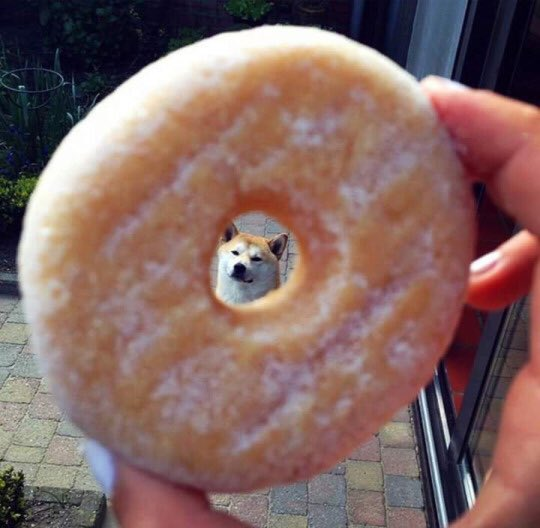

In [12]:
#We need only tweets, retweets are indicated with retweet_status_id, in total
#181 rows have to be deleted from the frame. 
#(from df_twitter.info: 6   retweeted_status_id         181 non-null    float64)
#Select the rows to be removed.

total_rows=clean_twitter.shape[0]

#create df with all none empty retweet)status_id
a=clean_twitter.retweeted_status_id.dropna()

#remove all rows in the temporary dataframe from the twitter dataframe.
clean_twitter.drop(labels=a.index,inplace=True)

In [13]:
#Test if the 181 rows are gone. 2356 - 181 = 2175
clean_twitter.info()
print('Removed lines: {}'.format(total_rows - clean_twitter.shape[0]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [14]:
clean_twitter.query('tweet_id == 759566828574212096')
# no outpute expected

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [15]:
clean_twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


<a id='remove'></a> 
### 2 Remove not needed columns
There are a number of columns not needed for the analysis


In [16]:
#Remove the 2 reply* columns and the 3 retweet* colums
total_columns=clean_twitter.shape[1]
clean_twitter = clean_twitter.drop(['in_reply_to_status_id','in_reply_to_user_id'],axis=1)
clean_twitter = clean_twitter.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)

In [17]:
clean_twitter.info()
# below the 5 columns should have gone
print('Removed columns: {}'.format(total_columns - clean_twitter.shape[1]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2175 non-null   int64 
 6   rating_denominator  2175 non-null   int64 
 7   name                2175 non-null   object
 8   doggo               2175 non-null   object
 9   floofer             2175 non-null   object
 10  pupper              2175 non-null   object
 11  puppo               2175 non-null   object
dtypes: int64(3), object(9)
memory usage: 144.4+ KB
Removed columns: 5


<a id='Timestamp'></a>
### 3 Change Timestamp


In [18]:
#convert the timestamp to a datetime object 
#(from df_twitter.info 3   timestamp                   2356 non-null   object)
clean_twitter.timestamp = pd.to_datetime(clean_twitter.timestamp)

In [19]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

In [20]:
clean_twitter.timestamp.head(1)

0   2017-08-01 16:23:56+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

<a id='source'></a>
### 4. Change source column
Source is object change it to catagorical after replacing the URL content to shorter descriptions.


In [21]:
#Get all the values
clean_twitter.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2042
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [22]:
#There are only 4 values in URL format replace it with a shorthand notation
clean_twitter.source=clean_twitter.source.str.extract('(iPhone|Vine|Web|TweetDeck)')

#Check the result
clean_twitter.source.value_counts()

iPhone       2042
Vine           91
Web            31
TweetDeck      11
Name: source, dtype: int64

In [23]:
#Change the dtype to category 
#(from df_twitter.info  4   source                      2356 non-null   object)
clean_twitter.source=clean_twitter.source.astype('category')

In [24]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

<a id='tweetid'></a>
### 5. Tweet_id convert to string
The tweetid can be very long according the twitter specification a string object is preferd

In [25]:
#the column tweet_id should be of type object not Int64
clean_twitter.tweet_id = clean_twitter.tweet_id.astype(str)
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

In [26]:
#The same operation for the other two dataframes
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 119.6+ KB


In [27]:
#the column tweet_id should be of type object not Int64
clean_predict.tweet_id = clean_predict.tweet_id.astype(str)
clean_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 111.5+ KB


In [28]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   id                             2331 non-null   int64              
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [29]:
#Tweet_id is called id in this dataframe, we rename it to have all the same names
clean_extra.id = clean_extra.id.astype(str)
clean_extra.rename(columns={'id':'tweet_id'},inplace=True)
clean_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   tweet_id                       2331 non-null   object             
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

<a id='ratings'></a>
### 6&7. Ratings
The ratings have several quality problems. 
First of all, the data is not always extrated in the correct way.

Second Numerator and Denominator should be floats as a rating can be 13.5/10


In [30]:
clean_twitter.text.sample(10)

2105       Honor to rate this dog. Great teeth. Nice horns. Unbelievable posture. Fun to pet. Big enough to ride. 10/10 rad dog https://t.co/7JMAHdJ6A4
1172                                                              This is Ralphé. He patrols the lake. Looking for babes. 11/10 https://t.co/Pb6iMmo0wk
2100            Meet Danny. He's too good to look at the road when he's driving. Absolute menace. 6/10 completely irresponsible https://t.co/I1lMUy1FqH
490     Meet Gary, Carrie Fisher's dog. Idk what I can say about Gary that reflects the inspirational awesomeness that was Carrie Fisher. 14/10 RIP ...
305     This is Lucy. She spent all morning overseeing the shoveling of the driveway. H*ckin hard work. 13/10 very good girl Lucy https://t.co/gA2GE...
442             This is Jazzy. She just found out that sandwich wasn't for her. Shocked and puppalled. 13/10 deep breaths Jazzy https://t.co/52cItP0vIO
110                                                                                     

In [31]:
df_twitter.rating_numerator.value_counts().head(10)

12    558
11    464
10    461
13    351
9     158
8     102
7      55
14     54
5      37
6      32
Name: rating_numerator, dtype: int64

In [32]:
#From the text extract number followed bij / followed by number where number can be nn.nn or nn
clean_twitter[['rating_numerator','rating_denominator']]=clean_twitter.text.str.extract('([0-9]+\.?[0-9]*)\/([0-9]+\.?[0-9]*)')

In [33]:
#search for a floating value 11.26 and 13.5 checking if they are correct extracted
clean_twitter[clean_twitter.text.str.contains('11.26')]['tweet_id']

1712    680494726643068929
Name: tweet_id, dtype: object

In [34]:
clean_twitter.query('tweet_id == "680494726643068929"')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10


In [35]:
clean_twitter[clean_twitter.text.str.contains('13.5')]['tweet_id']

45    883482846933004288
Name: tweet_id, dtype: object

In [36]:
clean_twitter.query('tweet_id == "883482846933004288"')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5,10


In [37]:
#convert to floats
clean_twitter = clean_twitter.astype({'rating_numerator': 'float', 'rating_denominator': 'float'})

In [38]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   float64            
 6   rating_denominator  2175 non-null   float64            
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

<a id='dognames'></a>
### 8. Dognames
Clean the columns name. Not alle the values are actual dognames.
Of course not alle tweets have a dogname in the text.

In [39]:
df_twitter.name.value_counts().head(10)
# the dogname a is not an actual dogname

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
Oliver      11
Penny       10
Lola        10
Tucker      10
Winston      9
Name: name, dtype: int64

In [40]:
#Some checking if the text contains no dogname
df_twitter.query('name == "None"')['text'].head(10)

5     Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek h...
7      When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq
12                 Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm
24                                   You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV
25    This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t....
30                                          @NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution
32                                                                                                 R

As can been seen, in the above example most text lines contains no dognames (except howard in row 35), but mostly they do not contain dognames.  

Further dognames are normally written with the first letter a Capital letter. Thus 'Charlie' would be a dogname and 'light' would be no. A test checking if alle names start with capital letter and if not we replace it with None.

No further extracting from Dognames will happen we will stay with the names found.

In [41]:
# Search for all none dognames
clean_twitter['name'].str.extract('(^[a-z][a-z]*)').value_counts()

a               55
the              8
an               6
one              4
very             4
just             3
quite            3
actually         2
not              2
getting          2
infuriating      1
all              1
this             1
by               1
his              1
incredibly       1
space            1
life             1
light            1
unacceptable     1
my               1
officially       1
old              1
such             1
mad              1
dtype: int64

In [42]:
#Create a new column with a meaningfull name 
clean_twitter['dogname']=clean_twitter.name.str.replace('(^[a-z][a-z]*)','None')

In [43]:
#Crosscheck
clean_twitter[['name','dogname']].sample(25)

,name,dogname
2071,Phred,Phred
1823,None,None
1417,Claude,Claude
1463,Phil,Phil
769,Jeffrey,Jeffrey
1589,Mona,Mona
1427,None,None
1585,Jackson,Jackson
2262,George,George
1010,None,None


In [44]:
#Another check, no Names starting with a lower letter: should be empty
clean_twitter['dogname'].str.extract('(^[a-z][a-z]*)').value_counts()

Series([], dtype: int64)

In [45]:
#Remove the old column name from the dataframe
clean_twitter.drop(columns='name',axis=1,inplace=True)

In [46]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   float64            
 6   rating_denominator  2175 non-null   float64            
 7   doggo               2175 non-null   object             
 8   floofer             2175 non-null   object             
 9   pupper              2175 non-null   object             
 10  puppo               2175 non-null   object             
 11  dogname             2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

In [47]:
#check for duplicates
clean_twitter.duplicated('tweet_id').sum()

0

In [48]:
clean_twitter.shape

(2175, 12)

<a id='predict'></a>
### 9. Meaningfull column names

The prediction has three predictions in row, each with a breed {P1..P3}, a Confidence level {P1_conf...P3_conf} and a boolean indicating if it is a dog or not.

The names will be changed to
- First_guess, Second_guess, Third_guess
- First_confidence, Second_confidence, Third_confidence
- First_dog, Second_dog, Third_dog



In [49]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 119.6+ KB


In [50]:
clean_predict.rename(columns={'p1': 'First_breed',
                              'p2': 'Second_breed',
                              'p3': 'Third_breed'}, inplace=True)

In [51]:
clean_predict.rename(columns={'p1_conf': 'First_confidence',
                              'p2_conf': 'Second_confidence',
                              'p3_conf': 'Third_confidence'}, inplace=True)

In [52]:
clean_predict.rename(columns={'p1_dog': 'First_dog',
                              'p2_dog': 'Second_dog',
                              'p3_dog': 'Third_dog'}, inplace=True)

In [53]:
clean_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           2075 non-null   object 
 1   jpg_url            2075 non-null   object 
 2   img_num            2075 non-null   int64  
 3   First_breed        2075 non-null   object 
 4   First_confidence   2075 non-null   float64
 5   First_dog          2075 non-null   bool   
 6   Second_breed       2075 non-null   object 
 7   Second_confidence  2075 non-null   float64
 8   Second_dog         2075 non-null   bool   
 9   Third_breed        2075 non-null   object 
 10  Third_confidence   2075 non-null   float64
 11  Third_dog          2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 111.5+ KB


<a id='tidy'></a><a id='puppo'></a>
### Tidiness
There are two issues to resolve
1. The doge stages should be in one column instead of four
2. The tables should be combined to one meaningfull dataset

In [54]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [55]:
#create a new column with all dog stages in the column, replace None in the same action replace('', np.nan, inplace=True)
clean_twitter['stage'] = clean_twitter[['doggo', 'floofer','pupper','puppo']].apply(lambda x: "".join(x).replace('None',''), axis=1)

In [56]:
#check the result
clean_twitter.stage.value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
Name: stage, dtype: int64

In [57]:
#we have to correct a few values
clean_twitter.stage=clean_twitter.stage.str.replace('doggop','doggo,p')
clean_twitter.stage=clean_twitter.stage.str.replace('doggof','doggo,f')
clean_twitter.stage.value_counts()

                 1831
pupper            224
doggo              75
puppo              24
doggo,pupper       10
floofer             9
doggo,floofer       1
doggo,puppo         1
Name: stage, dtype: int64

In [58]:
#remove the obsolete columns
clean_twitter.drop(columns=['doggo', 'floofer','pupper','puppo'],inplace=True)
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   float64            
 6   rating_denominator  2175 non-null   float64            
 7   dogname             2175 non-null   object             
 8   stage               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC](1), float64(2), object(5)
memory usage: 112.7+ KB


In [59]:
clean_twitter.sample(15)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dogname,stage
696,786664955043049472,2016-10-13 20:28:35+00:00,iPhone,"""Honestly Kathleen I just want more Ken Bone"" 12/10 https://t.co/HmlEvAMP4r",https://twitter.com/dog_rates/status/786664955043049472/photo/1,12.0,10.0,None,
1857,675517828909424640,2015-12-12 03:29:35+00:00,iPhone,12/10 stay woke https://t.co/XDiQw4Akiw,https://twitter.com/dog_rates/status/675517828909424640/photo/1,12.0,10.0,None,
54,881666595344535552,2017-07-03 00:11:11+00:00,iPhone,This is Gary. He couldn't miss this puppertunity for a selfie. Flawless focusing skills. 13/10 would boop intensely https://t.co/7CSWCl8I6s,https://twitter.com/dog_rates/status/881666595344535552/photo/1,13.0,10.0,Gary,
356,830583320585068544,2017-02-12 01:04:29+00:00,iPhone,This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13.0,10.0,Lilly,
1935,674008982932058114,2015-12-07 23:33:58+00:00,iPhone,This pup is sad bc he didn't get to be the toy car. Also he has shitty money management skills. 10/10 still cute tho https://t.co/PiSXXZjDSJ,https://twitter.com/dog_rates/status/674008982932058114/photo/1,10.0,10.0,None,
1584,687096057537363968,2016-01-13 02:17:20+00:00,iPhone,This pupper's New Year's resolution was to become a Hershey's kiss. 11/10 she's super pumped about it https://t.co/D7jYj6vdwC,https://twitter.com/dog_rates/status/687096057537363968/photo/1,11.0,10.0,None,pupper
83,876537666061221889,2017-06-18 20:30:39+00:00,iPhone,I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu,https://twitter.com/mpstowerham/status/876162994446753793,14.0,10.0,None,
2324,666421158376562688,2015-11-17 01:02:40+00:00,iPhone,*internally screaming* 12/10 https://t.co/YMcrXC2Y6R,https://twitter.com/dog_rates/status/666421158376562688/photo/1,12.0,10.0,None,
30,886267009285017600,2017-07-15 16:51:35+00:00,iPhone,@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,12.0,10.0,None,
967,750381685133418496,2016-07-05 17:31:49+00:00,iPhone,13/10 such a good doggo\n@spaghemily,NaN,13.0,10.0,None,doggo


 <a id='combine'></a>
 ### Create one final dataframe

In [60]:
clean_twitter.shape, clean_extra.shape, clean_predict.shape

((2175, 9), (2331, 32), (2075, 12))

In [61]:
clean_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   tweet_id                       2331 non-null   object             
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [62]:
#create first a temporary dataframe with the data needed from the archive
df_tmp=clean_twitter.merge(clean_extra, on='tweet_id', how='left')[['tweet_id','retweet_count','favorite_count']]

In [63]:
df_tmp.head(3)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7454.0,35309.0
1,892177421306343426,5535.0,30560.0
2,891815181378084864,3661.0,23002.0


In [64]:
#Merge this with the twitter data
twitter_tmp=pd.merge(clean_twitter,df_tmp,on='tweet_id', how='inner' )
twitter_tmp.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dogname,stage,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,,7454.0,35309.0
1,892177421306343426,2017-08-01 00:17:27+00:00,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 h...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,,5535.0,30560.0
2,891815181378084864,2017-07-31 00:18:03+00:00,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZn...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,,3661.0,23002.0


In [65]:
#create the final dataframe with also the predicted data
twitter_master=pd.merge(twitter_tmp,clean_predict,on='tweet_id', how='left')
twitter_master.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dogname,stage,retweet_count,...,img_num,First_breed,First_confidence,First_dog,Second_breed,Second_confidence,Second_dog,Third_breed,Third_confidence,Third_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,,7454.0,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 h...",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,,5535.0,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:00,iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZn...,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,,3661.0,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


In [66]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   float64            
 6   rating_denominator  2175 non-null   float64            
 7   dogname             2175 non-null   object             
 8   stage               2175 non-null   object             
 9   retweet_count       2168 non-null   float64            
 10  favorite_count      2168 non-null   float64            
 11  jpg_url             1994 non-null   object             
 12  img_num             1994 non-null 

In [67]:
#write the cleaned data to a file
twitter_master.to_csv('twitter_archive_master.csv')

## Insights

    1 Is there a relation between the number of retweets and the favorites count.
    2 Which dog breeds are most detected by the neural network and how often it missed a real dog.
    3 Which dog names are most favorit and do the appear in the top 500 dogname list
    4 What are the ratings for the dogs.

### 1 Relation between reteets and favorits

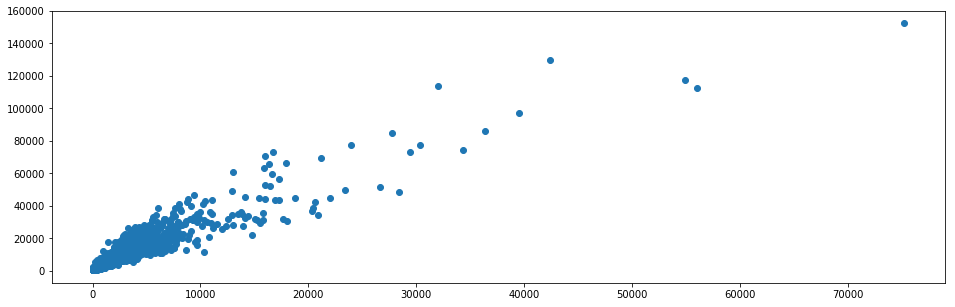

In [68]:
# Create a scatterplot checking the relation between retweet_count and favorite_count.
plt.figure(figsize = [16, 5])
base_color = sns.color_palette()[0]
plt.scatter(data=twitter_master, x='retweet_count', y='favorite_count',color=base_color);

In [69]:
#To assess if there is a relation between the retweet_count and the favorite count 
#we check the correlation between the two columns
twitter_master.retweet_count.corr(twitter_master.favorite_count)

0.9264850985242628

As can be seen from the scatterplot and the calculation of the correlation. There is a strong positive relation between the retweet_count and the favorit count. In other words tweets retweeted often are also favorite.

### 2 Detecting dogbreed
We split it in two question.
- What is the ratio between dog/none dog detection
- what are the top most dog breeds


In [70]:
# The ratio between dog and none dog detection
twitter_master.First_dog.mean(skipna=True), twitter_master.Second_dog.mean(skipna=True), twitter_master.Third_dog.mean(skipna=True)

(0.7407221664994985, 0.7497492477432297, 0.7251755265797393)

In [71]:
#what is detected instead of a dog Breed?
twitter_master.query('First_dog == False')['First_breed'].value_counts().head(10)

seat_belt      21
teddy          18
web_site       15
dingo           9
tennis_ball     9
doormat         7
bath_towel      7
swing           7
hamster         7
Siamese_cat     7
Name: First_breed, dtype: int64

In [72]:
#The top ten dog breads for the first, second and third prediction
twitter_master['First_breed'].value_counts().head(10)

golden_retriever      139
Labrador_retriever     95
Pembroke               88
Chihuahua              79
pug                    54
chow                   41
Samoyed                40
Pomeranian             38
toy_poodle             38
malamute               29
Name: First_breed, dtype: int64

In [73]:
twitter_master['Second_breed'].value_counts().head(10)

Labrador_retriever          96
golden_retriever            82
Cardigan                    72
Chihuahua                   43
Chesapeake_Bay_retriever    40
French_bulldog              39
Pomeranian                  39
toy_poodle                  36
Siberian_husky              33
cocker_spaniel              32
Name: Second_breed, dtype: int64

In [74]:
twitter_master['Third_breed'].value_counts().head(10)

Labrador_retriever           76
Chihuahua                    57
golden_retriever             46
Eskimo_dog                   36
kelpie                       33
chow                         31
kuvasz                       31
Staffordshire_bullterrier    30
beagle                       30
toy_poodle                   29
Name: Third_breed, dtype: int64

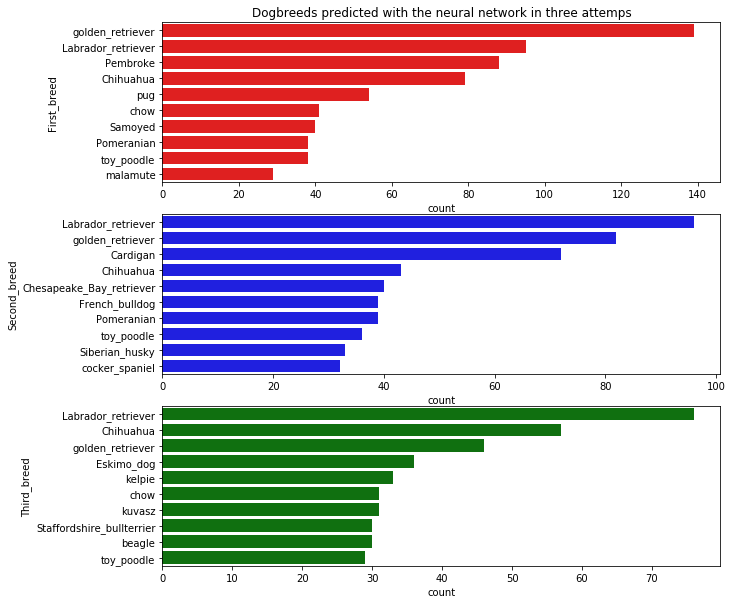

In [75]:
#lets do the same for all three the predictions but visual
plt.figure(figsize = [10, 10])
plt.subplot(3,1,1)
plt.title('Dogbreeds predicted with the neural network in three attemps');
sns.countplot(y='First_breed',data=twitter_master,order=pd.value_counts(twitter_master['First_breed']).iloc[:10].index, color='r');
plt.subplot(3,1,2)
sns.countplot(y='Second_breed',data=twitter_master,order=pd.value_counts(twitter_master['Second_breed']).iloc[:10].index, color='b');
plt.subplot(3,1,3)
sns.countplot(y='Third_breed',data=twitter_master,order=pd.value_counts(twitter_master['Third_breed']).iloc[:10].index, color='g');

As can bee seen from the above code, the prediction gives approximatly 3 out of 4 times a dog breed.

Most of the time the prediction network predicts a 'golden retriever' or 'labrador retriever'. 
This is not an indication that the breed is detected correctly for that to conclude the prediction should be held against the actual dog breed to verify.

### 3 Favorite dognames
A list of favorite dognames is retrieved from the website: www.puppyleaks.com/popular-dog-names and put into a file

In [76]:
# read the file with the top 500 dognames
dognames=[]
with open('dognames.txt', mode='r',newline='\n') as dogfile:
    dogname=dogfile.readlines()
    for row in dogname:
        dognames.append(row.strip('\n'))
        
#convert it to a set
dognames=set(dognames)

In [77]:
#create set with all dognames in the tweets
alldognames = set(twitter_master.dogname.unique())

In [78]:
#combine sets such that the resulting set contains names in both sets
populardognames=alldognames.intersection(dognames)

In [79]:
#create two lists wikth the names and count
names=[]
values=[]
for key, value in twitter_master.dogname.value_counts(sort=True).to_dict().items():
    if key in populardognames:
        names.append(key)
        values.append(value)


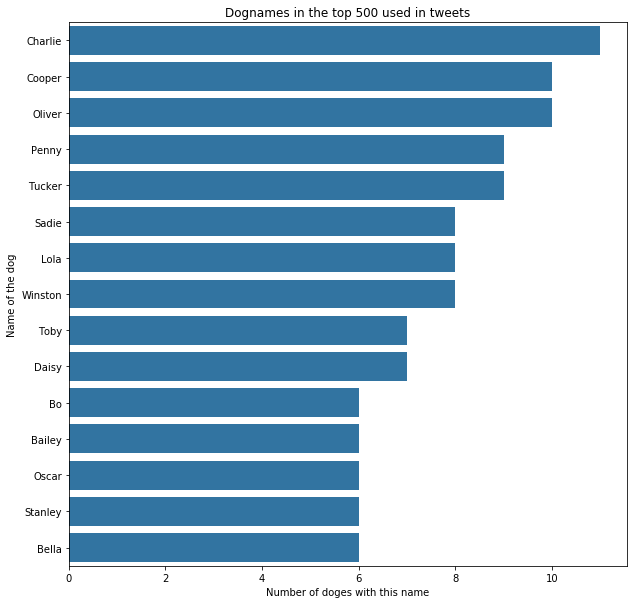

In [80]:
# use the above list to plot the top 15 dognames
plt.figure(figsize = [10, 10])
sns.barplot(y=names[:15],x=values[:15],color=base_color,orient='h');
plt.xlabel('Number of doges with this name');
plt.ylabel('Name of the dog');
plt.title('Dognames in the top 500 used in tweets');

In [81]:
#From the top 500 list the following 15 dognames are als favorite in the tweets
names[:15]

['Charlie',
 'Cooper',
 'Oliver',
 'Penny',
 'Tucker',
 'Sadie',
 'Lola',
 'Winston',
 'Toby',
 'Daisy',
 'Bo',
 'Bailey',
 'Oscar',
 'Stanley',
 'Bella']

In [82]:
#Taking the top 15 dognames in the tweets will reveil that not all top names in the tweets are in the top 500
# for example Lucy is not (rank 2) and 
twitter_master.dogname.value_counts(sort=True).head(16)

None       784
Charlie     11
Lucy        11
Cooper      10
Oliver      10
Penny        9
Tucker       9
Sadie        8
Lola         8
Winston      8
Toby         7
Daisy        7
Bo           6
Bailey       6
Oscar        6
Stanley      6
Name: dogname, dtype: int64

Shown above is the list with the popular dognames. Most of the names found in the tweets are also in the top 500 of popular dognames. 

In [83]:
tmp_master=twitter_master.copy()
tmp_master = tmp_master.query('stage != ""')
dog_stages = ['doggo', 'puppo', 'pupper', 'floofer']
dog_stages=['floofer','puppo','doggo', 'pupper']
vclasses = pd.api.types.CategoricalDtype(ordered=True, categories=dog_stages)
tmp_master['stage'] = tmp_master['stage'].astype(vclasses);
tmp_master['divider'] = tmp_master.favorite_count/tmp_master.retweet_count
tmp_master.divider.median()

3.291032608695652

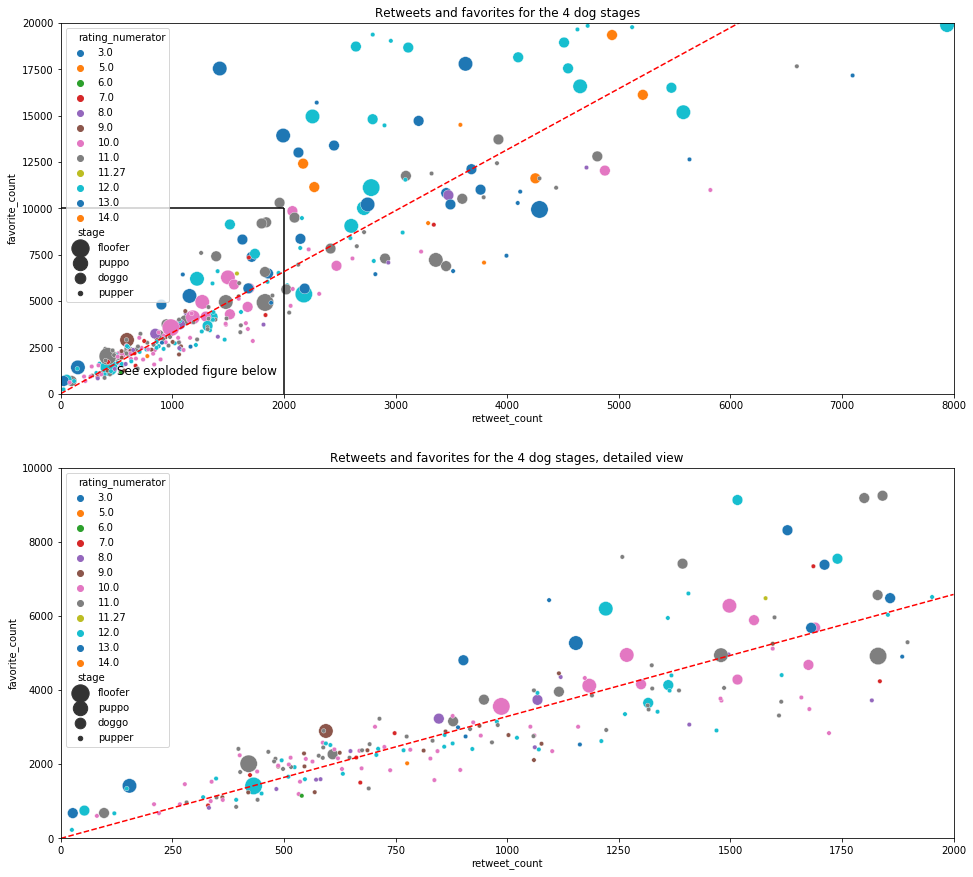

In [84]:
plt.figure(figsize = [16, 15])

plt.subplot(2,1,1)
plt.xlim(0,8000)
plt.ylim(0,20000)
base_color = sns.color_palette()[0]
sns.scatterplot(data=tmp_master, 
                x='retweet_count', y='favorite_count',palette='tab10',size='stage', 
                hue='rating_numerator',sizes=(20,300),
                markers=['o','v','p','h']);
plt.vlines(2000,0,10000)
plt.hlines(10000,2000,0)
plt.text(500,1000,"See exploded figure below",fontsize=12)
plt.title("Retweets and favorites for the 4 dog stages");
x=[0,8000]
y=[0,3.291*8000]
plt.plot(x,y, color='r',linestyle='--');

plt.subplot(2,1,2)
plt.xlim(0,2000)
plt.ylim(0,10000)
base_color = sns.color_palette()[1]
sns.scatterplot(data=tmp_master, 
                x='retweet_count', y='favorite_count',palette='tab10',size='stage', 
                hue='rating_numerator',sizes=(20,300),
                markers=['o','v','p','h']);
plt.title("Retweets and favorites for the 4 dog stages, detailed view");
x=[0,2000]
y=[0,3.291*2000]
plt.plot(x,y, color='r',linestyle='--');

From the two figures above we can see that the stage of the dog has some impact on the number of retweets and favorites. The floofer and the puppo in general have higher counts. Be aware that these present a smaller part of the total dog's in this overview.

Also can be seen that the retweet counts are lower than the favorites count. The red dashed line is the line with a slope of 3,29 which is the median of the difference between the two. The floofer and puppo are the dogs which in general are above the line meaning that they seems to be even more favorite then the puppers.